In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import transforms, models

<br/>
<br/>

## Get the model and disable the parameters to do not train

In [2]:
vgg = models.vgg19(pretrained=True).features

# Stop the train for each parameter
for param in vgg.parameters():
    param.requires_grad_(False)

<br/>
<br/>

## Define the device CPU or GPU

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
vgg.to(device)

Device: cuda


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [4]:
def get_image(path, max_size = 400):
    image = Image.open(path).convert('RGB')

    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    transform_pipe = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    image = transform_pipe(image)[:3, :, :].unsqueeze(0)

    return image

In [5]:
content = get_image('./images/Recife.jpg').to(device)
style = get_image('./images/Surrealism.jpg').to(device)

In [6]:
print(content.shape)
print()
print(style.shape)

torch.Size([1, 3, 400, 400])

torch.Size([1, 3, 400, 400])


In [7]:
def convert_tensor_to_img(tensor):

    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

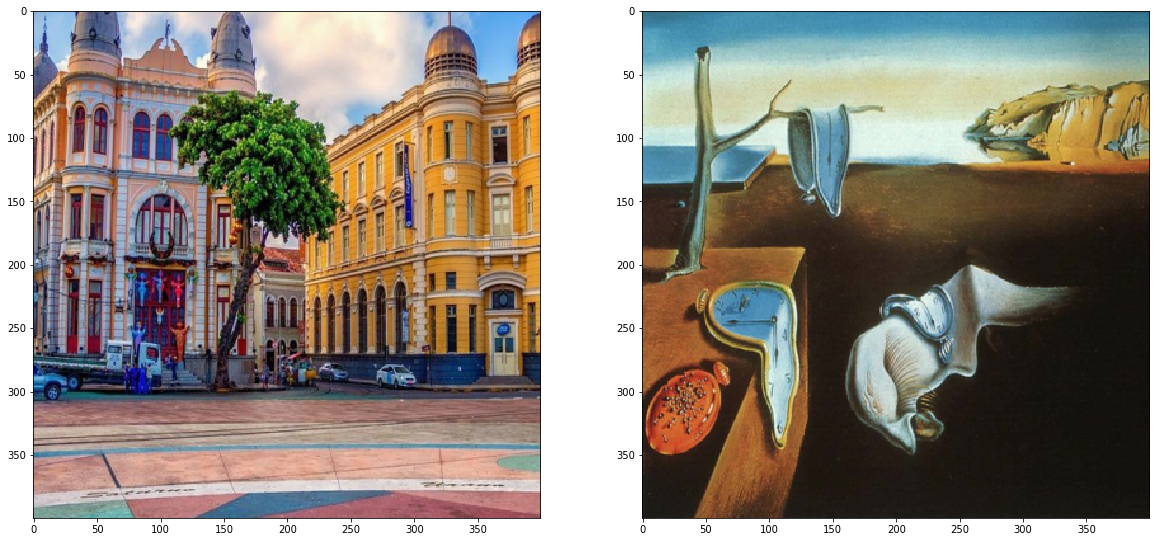

In [8]:
_, axis = plt.subplots(1, 2, figsize=(20, 10))

axis[0].imshow(convert_tensor_to_img(content))
axis[1].imshow(convert_tensor_to_img(style))

<br/>
<br/>

## Get the gram matrix

In [9]:
def gram_matrix(tensor):

    _, d, h, w = tensor.size()
    gram = tensor.view(d, h * w)
    gram = gram.mm(gram.t())

    return gram

<br/>
<br/>

## Extract the features from the VGG19

In [10]:
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [11]:
def extract_features(image, model, layers=None):

    if layers is None:
        layers = {
            '0': 'Conv_1_1',
            '5': 'Conv_2_1',
            '10': 'Conv_3_1',
            '19': 'Conv_4_1',
            '21': 'Conv_4_2',
            '28': 'Conv_5_1'
        }

    
    features = {}
    X = image
    for name, layer in model._modules.items():
        X = layer(X)

        if name in layers:
            features[ layers[name] ] = X
    
    return features

<br/>
<br/>

## Get the grams and features

In [12]:
# Get the features of the model from each image
content_features = extract_features(content, vgg)
style_features = extract_features(style, vgg)

# Get the gram matrix from the style
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# Create the target image from copy the content
target = content.clone().requires_grad_(True).to(device)

<br/>
<br/>

## Define the weights and loss

In [13]:
weights = {
    'Conv_1_1': 1.0,
    'Conv_2_1': 0.8,
    'Conv_3_1': 0.6,
    'Conv_4_1': 0.4,
    'Conv_4_2': 0.2,
    'Conv_5_1': 0.1
}

content_weight = 1
style_weight = 1e5

<br/>
<br/>

## Train

Total loss:  553401.6875


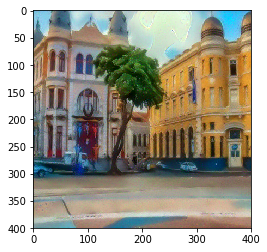

Total loss:  363237.59375


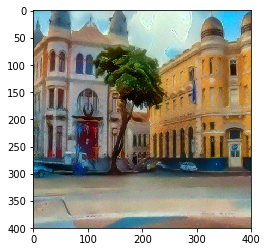

In [14]:
epochs = 1000
optmizer = torch.optim.Adam([target], lr=0.01)

for e in range(epochs):

    style_loss = 0

    target_features = extract_features(target, vgg)
    target_grams = {layer: gram_matrix(target_features[layer]) for layer in target_features}

    content_loss = torch.mean( ( style_features['Conv_4_2'] - content_features['Conv_4_2'] ) ** 2 )

    for layer in weights:
        _, d, h, w = target_features[layer].shape

        layer_style_loss = weights[ layer ] * torch.mean( ( target_grams[layer] - style_grams[layer] ) ** 2 )

        style_loss += layer_style_loss / (d * h * w)
    
    total_loss = content_weight * content_loss + style_weight * style_loss

    optmizer.zero_grad()
    total_loss.backward()
    optmizer.step()

    if  (e+1) % 500 == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(convert_tensor_to_img(target))
        plt.show()

<br/>
<br/>

## Recife Before | Recife After

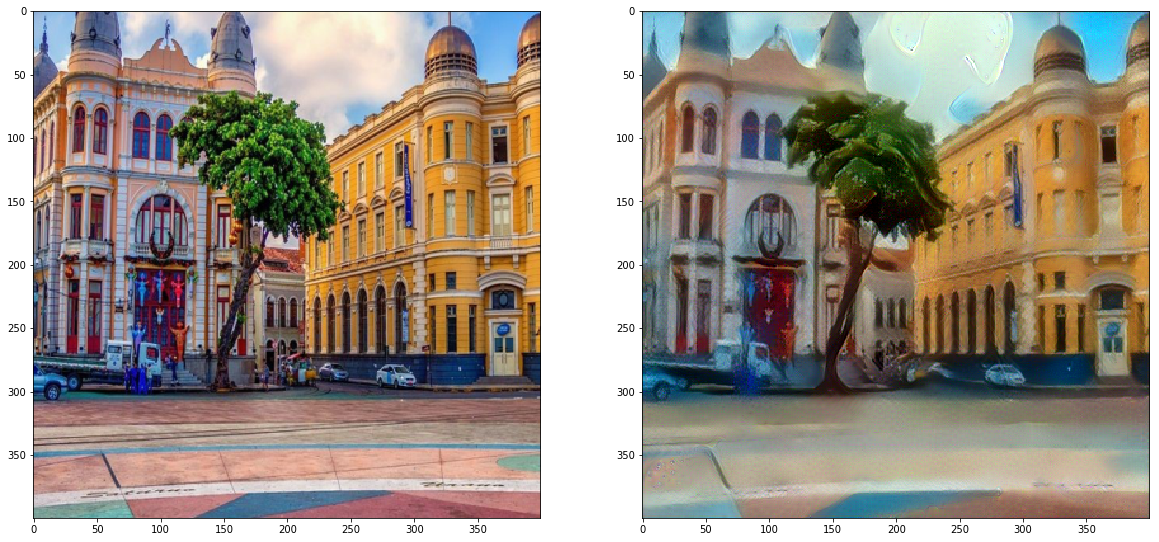

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(convert_tensor_to_img(content))
ax2.imshow(convert_tensor_to_img(target))